##Overview
In the RNN lesson, we were constrained to using the representation at the very end but what if we could give contextual weight to each encoded input ($h_i$) when making our prediction? This is also preferred because it can help mitigate the vanishing gradient issue which stems from processing very long sequences. Below is attention applied to the outputs from an RNN. In theory, the outputs can come from anywhere where we want to learn how to weight amongst them but since we're working with the context of an RNN from the previous lesson , we'll continue with that.

<img src='https://madewithml.com/static/images/foundations/attention/attention.png'>

<br>
<br>
$$\alpha = softmax(W_{attn}h)$$

$$c_t = \sum_{i=1}^{n} \alpha_{t,i}h_i$$

<br>

Variable|Description
---|---
N|batch size
M|max sequence length in the batch
H|hidden dim, model dim, etc.
$h$|RNN outputs (or any group of outputs you want to attend to) $\in \mathbb{R}^{NXMXH}$
$\alpha_{t,i}$|alignment function context vector $c_t$ (attention in our case) $\$$
$W_{attn}$|	attention weights to learn $\in \mathbb{R}^{HX1}$
$c_t$|context vector that accounts for the different inputs with attention


###Objective:
- At it's core, attention is about learning how to weigh a group of encoded representations to produce a context-aware representation to use for downstream tasks. This is done by learning a set of attention weights and then using softmax to create attention values that sum to 1.

###Advantages:
- Learn how to account for the appropriate encoded representations regardless of position.

###Disadvantages:
- Another compute step that involves learning weights.

###Miscellaneous:
- Several state-of-the-art approaches extend on basic attention to deliver highly context-aware representations (ex. self-attention).

##Set up
Let's set our seed and device for our main task.

In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
SEED = 1234


In [3]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU


In [4]:
# Set seeds for reproducibility
set_seeds(seed=SEED)


In [5]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)


cpu


##Load data
We will download the [AG News dataset](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html), which consists of 120K text samples from 4 unique classes (Business, Sci/Tech, Sports, World)

In [6]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/news.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()


,title,category
0,Sharon Accepts Plan to Reduce Gaza Army Operat...,World
1,Internet Key Battleground in Wildlife Crime Fight,Sci/Tech
2,July Durable Good Orders Rise 1.7 Percent,Business
3,Growing Signs of a Slowing on Wall Street,Business
4,The New Faces of Reality TV,World


##Preprocessing
We're going to clean up our input data first by doing operations such as lower text, removing stop (filler) words, filters using regular expressions, etc.

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re


In [8]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print (STOPWORDS[:5])
porter = PorterStemmer()


['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in parenthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text


In [11]:
# Sample
text = "Great week for the NYSE!"
preprocess(text=text)


'great week nyse'

In [12]:
# Apply to dataframe
preprocessed_df = df.copy()
preprocessed_df.title = preprocessed_df.title.apply(preprocess)
print (f"{df.title.values[0]}\n\n{preprocessed_df.title.values[0]}")


Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says

sharon accepts plan reduce gaza army operation haaretz says


>Warning

>If you have preprocessing steps like standardization, etc. that are calculated, you need to separate the training and test set first before applying those operations. This is because we cannot apply any knowledge gained from the test set accidentally (data leak) during preprocessing/training. However for global preprocessing steps like the function above where we aren't learning anything from the data itself, we can perform before splitting the data.

##Split data


In [13]:
import collections
from sklearn.model_selection import train_test_split


In [14]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15


In [15]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [16]:
# Data
X = preprocessed_df["title"].values
y = preprocessed_df["category"].values


In [17]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")


X_train: (84000,), y_train: (84000,)
X_val: (18000,), y_val: (18000,)
X_test: (18000,), y_test: (18000,)
Sample point: china battles north korea nuclear talks → World


##Label encoding
Next we'll define a LabelEncoder to encode our text labels into unique indices

In [18]:
import itertools


In [19]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


In [20]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index


{'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}

In [21]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")


y_train[0]: World
y_train[0]: 3


In [22]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")


counts: [21000 21000 21000 21000]
weights: {0: 4.761904761904762e-05, 1: 4.761904761904762e-05, 2: 4.761904761904762e-05, 3: 4.761904761904762e-05}


##Tokenizer
We'll define a Tokenizer to convert our text input data into token indices.

In [23]:
import json
from collections import Counter
from more_itertools import take


In [24]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None,
                 pad_token="<PAD>", oov_token="<UNK>",
                 token_to_index=None):
        self.char_level = char_level
        self.separator = "" if self.char_level else " "
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


>Warning

>It's important that we only fit using our train data split because during inference, our model will not always know every token so it's important to replicate that scenario with our validation and test splits as well.

In [25]:
# Tokenize
tokenizer = Tokenizer(char_level=False, num_tokens=5000)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print (tokenizer)


<Tokenizer(num_tokens=5000)>


In [27]:
# Sample of tokens
print (take(5, tokenizer.token_to_index.items()))
print (f"least freq token's freq: {tokenizer.min_token_freq}") # use this to adjust num_tokens


[('<PAD>', 0), ('<UNK>', 1), ('39', 2), ('b', 3), ('gt', 4)]
least freq token's freq: 14


In [28]:
# Convert texts to sequences of indices
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")


Text to indices:
  (preprocessed) → china battles north korea nuclear talks
  (tokenized) → [  16 1491  285  142  114   24]


##Padding
We'll need to do 2D padding to our tokenized text.

In [29]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences


In [30]:
# 2D sequences
padded = pad_sequences(X_train[0:3])
print (padded.shape)
print (padded)


(3, 6)
[[1.600e+01 1.491e+03 2.850e+02 1.420e+02 1.140e+02 2.400e+01]
 [1.445e+03 2.300e+01 6.560e+02 2.197e+03 1.000e+00 0.000e+00]
 [1.200e+02 1.400e+01 1.955e+03 1.005e+03 1.529e+03 4.014e+03]]


##Datasets
We're going to create Datasets and DataLoaders to be able to efficiently create batches with our data splits.

In [31]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, len(X), y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch)
        X = batch[:, 0]
        seq_lens = batch[:, 1]
        y = batch[:, 2]

        # Pad inputs
        X = pad_sequences(sequences=X)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        seq_lens = torch.LongTensor(seq_lens.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, seq_lens, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)


In [32]:
# Create datasets
train_dataset = Dataset(X=X_train, y=y_train)
val_dataset = Dataset(X=X_val, y=y_val)
test_dataset = Dataset(X=X_test, y=y_test)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  seq_len: {train_dataset[0][1]}\n"
    f"  y: {train_dataset[0][2]}")


Datasets:
  Train dataset:<Dataset(N=84000)>
  Val dataset: <Dataset(N=18000)>
  Test dataset: <Dataset(N=18000)>
Sample point:
  X: [  16 1491  285  142  114   24]
  seq_len: 6
  y: 3


In [33]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)
batch_X, batch_seq_lens, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  seq_lens: {list(batch_seq_lens.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f" seq_len: {batch_seq_lens[0]}\n"
    f"  y: {batch_y[0]}")


Sample batch:
  X: [64, 14]
  seq_lens: [64]
  y: [64]
Sample point:
  X: tensor([  16, 1491,  285,  142,  114,   24,    0,    0,    0,    0,    0,    0,
           0,    0])
 seq_len: 6
  y: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


##Trainer
Let's create the Trainer class that we'll use to facilitate training for our experiments.

In [34]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                y_prob = F.softmax(model(inputs), dim=1)

                # Store outputs
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model


##Attention
Attention applied to the outputs from an RNN. In theory, the outputs can come from anywhere where we want to learn how to weight amongst them but since we're working with the context of an RNN from the previous lesson , we'll continue with that.

<img src='https://madewithml.com/static/images/foundations/attention/attention.png'>

<br>
<br>
$$\alpha = softmax(W_{attn}h)$$

$$c_t = \sum_{i=1}^{n} \alpha_{t,i}h_i$$

<br>

Variable|Description
---|---
N|batch size
M|max sequence length in the batch
H|hidden dim, model dim, etc.
$h$|RNN outputs (or any group of outputs you want to attend to) $\in \mathbb{R}^{NXMXH}$
$\alpha_{t,i}$|alignment function context vector $c_t$ (attention in our case) $\$$
$W_{attn}$|	attention weights to learn $\in \mathbb{R}^{HX1}$
$c_t$|context vector that accounts for the different inputs with attention

In [35]:
import torch.nn.functional as F


The RNN will create an encoded representation for each word in our input resulting in a stacked vector that has dimensions $NXMXH$ , where N is the # of samples in the batch, M is the max sequence length in the batch, and H is the number of hidden units in the RNN.

In [36]:
BATCH_SIZE = 64
SEQ_LEN = 8
EMBEDDING_DIM = 100
RNN_HIDDEN_DIM = 128


In [37]:
# Embed
x = torch.rand((BATCH_SIZE, SEQ_LEN, EMBEDDING_DIM))


In [38]:
# Encode
rnn = nn.RNN(EMBEDDING_DIM, RNN_HIDDEN_DIM, batch_first=True)
out, h_n = rnn(x) # h_n is the last hidden state
print ("out: ", out.shape)
print ("h_n: ", h_n.shape)


out:  torch.Size([64, 8, 128])
h_n:  torch.Size([1, 64, 128])


In [39]:
# Attend
attn = nn.Linear(RNN_HIDDEN_DIM, 1)
e = attn(out)
attn_vals = F.softmax(e.squeeze(2), dim=1)
c = torch.bmm(attn_vals.unsqueeze(1), out).squeeze(1)
print ("e: ", e.shape)
print ("attn_vals: ", attn_vals.shape)
print ("attn_vals[0]: ", attn_vals[0])
print ("sum(attn_vals[0]): ", sum(attn_vals[0]))
print ("c: ", c.shape)


e:  torch.Size([64, 8, 1])
attn_vals:  torch.Size([64, 8])
attn_vals[0]:  tensor([0.1263, 0.1224, 0.1260, 0.1306, 0.1334, 0.1290, 0.1176, 0.1146],
       grad_fn=<SelectBackward0>)
sum(attn_vals[0]):  tensor(1.0000, grad_fn=<AddBackward0>)
c:  torch.Size([64, 128])


In [40]:
# Predict
fc1 = nn.Linear(RNN_HIDDEN_DIM, NUM_CLASSES)
output = F.softmax(fc1(c), dim=1)
print ("output: ", output.shape)


output:  torch.Size([64, 4])


>In a many-to-many task such as machine translation, our attentional interface will also account for the encoded representation of token in the output as well (via concatenation) so we can know which encoded inputs to attend to based on the encoded output we're focusing on. For more on this, be sure to explore [Bahdanau's attention paper.](https://arxiv.org/abs/1409.0473)

##Model
Now let's create our RNN based model but with the addition of the attention layer on top of the RNN's outputs.

In [41]:
RNN_HIDDEN_DIM = 128
DROPOUT_P = 0.1
HIDDEN_DIM = 100


In [42]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, rnn_hidden_dim,
                 hidden_dim, dropout_p, num_classes, padding_idx=0):
        super(RNN, self).__init__()

        # Initialize embeddings
        self.embeddings = nn.Embedding(
            embedding_dim=embedding_dim, num_embeddings=vocab_size,
            padding_idx=padding_idx)

        # RNN
        self.rnn = nn.RNN(embedding_dim, rnn_hidden_dim, batch_first=True)

        # Attention
        self.attn = nn.Linear(rnn_hidden_dim, 1)

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        # Embed
        x_in, seq_lens = inputs
        x_in = self.embeddings(x_in)

        # Encode
        out, h_n = self.rnn(x_in)

        # Attend
        e = self.attn(out)
        attn_vals = F.softmax(e.squeeze(2), dim=1)
        c = torch.bmm(attn_vals.unsqueeze(1), out).squeeze(1)

        # Predict
        z = self.fc1(c)
        z = self.dropout(z)
        z = self.fc2(z)

        return z


In [43]:
# Simple RNN cell
model = RNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    rnn_hidden_dim=RNN_HIDDEN_DIM, hidden_dim=HIDDEN_DIM,
    dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model = model.to(device) # set device
print (model.named_parameters)


<bound method Module.named_parameters of RNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (rnn): RNN(100, 128, batch_first=True)
  (attn): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


##Training


In [44]:
from torch.optim import Adam


In [45]:
NUM_LAYERS = 1
LEARNING_RATE = 1e-4
PATIENCE = 10
NUM_EPOCHS = 50


In [46]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [47]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)


In [48]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)


In [49]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 1 | train_loss: 1.19358, val_loss: 1.05929, lr: 1.00E-04, _patience: 10
Epoch: 2 | train_loss: 0.98981, val_loss: 0.92084, lr: 1.00E-04, _patience: 10
Epoch: 3 | train_loss: 0.86317, val_loss: 0.82448, lr: 1.00E-04, _patience: 10
Epoch: 4 | train_loss: 0.77194, val_loss: 0.75618, lr: 1.00E-04, _patience: 10
Epoch: 5 | train_loss: 0.70363, val_loss: 0.70741, lr: 1.00E-04, _patience: 10
Epoch: 6 | train_loss: 0.65153, val_loss: 0.67182, lr: 1.00E-04, _patience: 10
Epoch: 7 | train_loss: 0.61026, val_loss: 0.64496, lr: 1.00E-04, _patience: 10
Epoch: 8 | train_loss: 0.57685, val_loss: 0.62370, lr: 1.00E-04, _patience: 10
Epoch: 9 | train_loss: 0.55029, val_loss: 0.60672, lr: 1.00E-04, _patience: 10
Epoch: 10 | train_loss: 0.52736, val_loss: 0.59179, lr: 1.00E-04, _patience: 10
Epoch: 11 | train_loss: 0.50706, val_loss: 0.58168, lr: 1.00E-04, _patience: 10
Epoch: 12 | train_loss: 0.48981, val_loss: 0.57285, lr: 1.00E-04, _patience: 10
Epoch: 13 | train_loss: 0.47438, val_loss: 0.5658

##Evaluation


In [50]:
import json
from sklearn.metrics import precision_recall_fscore_support


In [51]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance


In [52]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [53]:
# Determine performance
performance = get_metrics(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))


{
  "precision": 0.8220038247226779,
  "recall": 0.8221666666666667,
  "f1": 0.8218540260147108,
  "num_samples": 18000.0
}


In [58]:
# Save artifacts
dir = Path("attn")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, "label_encoder.json"))
tokenizer.save(fp=Path(dir, 'tokenizer.json'))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, 'performance.json'), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)


##Inference

In [56]:
from pathlib import Path


In [54]:
def get_probability_distribution(y_prob, classes):
    """Create a dict of class probabilities from an array."""
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results


In [60]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
tokenizer = Tokenizer.load(fp=Path(dir, 'tokenizer.json'))
model = RNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    rnn_hidden_dim=RNN_HIDDEN_DIM, hidden_dim=HIDDEN_DIM,
    dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)


RNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (rnn): RNN(100, 128, batch_first=True)
  (attn): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [61]:
# Initialize trainer
trainer = Trainer(model=model, device=device)


In [62]:
# Dataloader
text = "The final tennis tournament starts next week."
X = tokenizer.texts_to_sequences([preprocess(text)])
print (tokenizer.sequences_to_texts(X))
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filler)
dataloader = dataset.create_dataloader(batch_size=batch_size)


['final tennis tournament starts next week']


In [63]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.decode(y_pred)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


['Sports']

In [64]:
# Class distributions
prob_dist = get_probability_distribution(y_prob=y_prob[0], classes=label_encoder.classes)
print (json.dumps(prob_dist, indent=2))


{
  "Sports": 0.9167444705963135,
  "World": 0.07204185426235199,
  "Business": 0.008844025433063507,
  "Sci/Tech": 0.0023696196731179953
}


##Interpretability
Let's use the attention values to see which encoded tokens were most useful in predicting the appropriate label.

In [65]:
import collections
import seaborn as sns


In [66]:
class InterpretAttn(nn.Module):
    def __init__(self, embedding_dim, vocab_size, rnn_hidden_dim,
                 hidden_dim, dropout_p, num_classes, padding_idx=0):
        super(InterpretAttn, self).__init__()

        # Initialize embeddings
        self.embeddings = nn.Embedding(
            embedding_dim=embedding_dim, num_embeddings=vocab_size,
            padding_idx=padding_idx)

        # RNN
        self.rnn = nn.RNN(embedding_dim, rnn_hidden_dim, batch_first=True)

        # Attention
        self.attn = nn.Linear(rnn_hidden_dim, 1)

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        # Embed
        x_in, seq_lens = inputs
        x_in = self.embeddings(x_in)

        # Encode
        out, h_n = self.rnn(x_in)

        # Attend
        e = self.attn(out)  # could add optional activation function (ex. tanh)
        attn_vals = F.softmax(e.squeeze(2), dim=1)

        return attn_vals


In [67]:
# Initialize model
interpretable_model = InterpretAttn(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    rnn_hidden_dim=RNN_HIDDEN_DIM, hidden_dim=HIDDEN_DIM,
    dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
interpretable_model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
interpretable_model.to(device)


InterpretAttn(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (rnn): RNN(100, 128, batch_first=True)
  (attn): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [68]:
# Initialize trainer
interpretable_trainer = Trainer(model=interpretable_model, device=device)


In [69]:
# Get attention values
attn_vals  = interpretable_trainer.predict_step(dataloader)
print (attn_vals.shape) # (N, max_seq_len)


(1, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


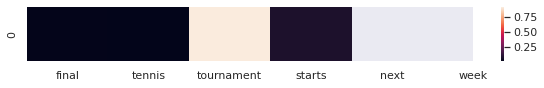

In [70]:
# Visualize a bi-gram filter's outputs
sns.set(rc={"figure.figsize":(10, 1)})
tokens = tokenizer.sequences_to_texts(X)[0].split(" ")
sns.heatmap(attn_vals, xticklabels=tokens)


The word `tournament` was attended to the most to result in the Sports label.

##Types of attention
We'll briefly look at the different types of attention and when to use each them.

##Soft (global) attention
Soft attention the type of attention we've implemented so far, where we attend to all encoded inputs when creating our context vector.

- **advantages**: we always have the ability to attend to all inputs in case something we saw much earlier/ see later are crucial for determing the output.
-**disadvantages**: if our input sequence is very long, this can lead to expensive compute.


##Hard attention
Hard attention is focusing on a specific set of the encoded inputs at each time step.

- **advantages**: we can save a lot of compute on long sequences by only focusing on a local patch each time.
- **disadvantages**: non-differentiable and so we need to use more complex techniques (variance reduction, reinforcement learning, etc.) to train.

<img src='https://madewithml.com/static/images/foundations/attention/soft_attention.png'>

##Local attention
Local attention blends the advantages of soft and hard attention. It involves learning an aligned position vector and empirically determining a local window of encoded inputs to attend to.

- **advantages**: apply attention to a local patch of inputs yet remain differentiable.
- **disadvantages**: need to determine the alignment vector for each output but it's a worthwhile trade off to determine the right window of inputs to attend to in order to avoid attending to all of them.

<img src='https://madewithml.com/static/images/foundations/attention/local_attention.png'>

##Self-attention
We can also use attention within the encoded input sequence to create a weighted representation that based on the similarity between input pairs. This will allow us to create rich representations of the input sequence that are aware of the relationships between each other. For example, in the image below you can see that when composing the representation of the token "its", this specific attention head will be incorporating signal from the token "Law" (it's learned that "its" is referring to the "Law").

<img src='https://madewithml.com/static/images/foundations/attention/self_attention.png'>